# Part 1

## Task 3

## Task 4

In [1]:
import pandas as pd

def prepare_data(df):
    # Check if 'type' column exists
    if 'type' in df.columns:
        included_types = ['political', 'fake', 'satire', 'reliable', 'conspiracy', 'bias', 'junksci', 'unreliable']
        df_filtered = df[df['type'].notna() & df['type'].isin(included_types)]
        reliable_types = ['reliable', 'political']
        df_filtered['type'] = df_filtered['type'].apply(lambda x: 1 if x in reliable_types else 0)
    else:
        # If 'type' column doesn't exist, proceed with the whole DataFrame
        df_filtered = df.copy()

    # Filtering rows where 'content' is not NA or empty after stripping whitespace
    df_filtered = df_filtered[df_filtered['content'].notna() & df_filtered['content'].str.strip().astype(bool)]
    # Filtering out rows where 'content' is numeric
    df_filtered = df_filtered[~df_filtered['content'].str.isnumeric().fillna(False)]

    return df_filtered

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import time

print('reading and splitting data...')
start_time = time.time()

path = 'cleaned.csv'
df = pd.read_csv(path)

df = prepare_data(df)

X = np.array(df['content'])
y = np.array(df['type'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

elapsed_time = time.time() - start_time
print(f"finished reading and splitting data in: {elapsed_time:.3f} seconds")

reading and splitting data...


/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_1781/796971196.py:9: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_1781/2451057150.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['type'] = df_filtered['type'].apply(lambda x: 1 if x in reliable_types else 0)


finished reading and splitting data in: 17.356 seconds


# Part 2

## Task 0

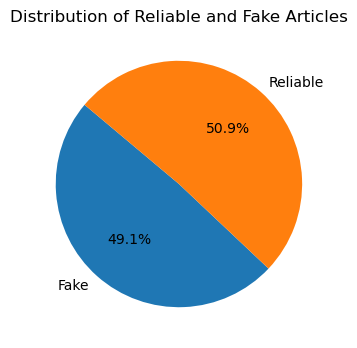

In [3]:
import matplotlib.pyplot as plt


def plot_distribution(counts):
    # Plotting
    labels = ['Fake', 'Reliable']
    plt.figure(figsize=(6, 4))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Reliable and Fake Articles')
    plt.show()


_, counts = np.unique(y, return_counts=True)
plot_distribution(counts)

## Task 1

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import re
from joblib import dump, load

def random_guessing_performance(X_train, y_train, X_val, y_val):
    uniform_classifier = DummyClassifier(strategy='uniform', random_state=0)
    uniform_classifier.fit(X_train, y_train)
    uniform_y_pred = uniform_classifier.predict(X_val)
    uniform_accuracy = accuracy_score(y_val, uniform_y_pred)
    print(f"Accuracy of Uniform Random classifier: {uniform_accuracy:.4f}")
    return uniform_accuracy


def guessing_most_frequent_performance(X_train, y_train, X_val, y_val):
    most_frequent_classifier = DummyClassifier(strategy='most_frequent', random_state=0)
    most_frequent_classifier.fit(X_train, y_train)
    most_frequent_y_pred = most_frequent_classifier.predict(X_val)
    most_frequent_accuracy = accuracy_score(y_val, most_frequent_y_pred)
    print(f"Accuracy of Most Frequent classifier: {most_frequent_accuracy:.4f}")
    return most_frequent_accuracy


def logistic_regression_performance(X_train, y_train, X_val, y_val, saveName=None, simple=False):
    print('fitting logistic regression...')
    start_time = time.time()

    parameters = {
        'C': [0.1, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs'],
        'tol': [1e-4, 1e-2],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 1000],
    }
    if simple:
        logistic_regression_classifier = LogisticRegression(solver="liblinear")
    else:
        logistic_regression_classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    
    logistic_regression_classifier.fit(X_train, y_train)
    logistic_regression_y_pred = logistic_regression_classifier.predict(X_val)
    logistic_regression_accuracy = accuracy_score(y_val, logistic_regression_y_pred)
    print(f"Accuracy of Logistic Regression classifier: {logistic_regression_accuracy:.4f}")

    elapsed_time = time.time() - start_time
    print(f"finished fitting logistic regression in: {elapsed_time:.3f} seconds")
    if saveName:
        dump(logistic_regression_classifier, saveName)
    return logistic_regression_accuracy


def display_model_comparisons(model_names, accuracies, title):
    # Combine the model names and accuracies, sort them by accuracies in descending order
    combined = sorted(zip(model_names, accuracies), key=lambda x: x[1], reverse=True)
    sorted_model_names, sorted_accuracies = zip(*combined)

    # Set up the matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(10, 5))  # Corrected to use a single axis

    # Plotting sorted accuracy scores
    ax.bar(sorted_model_names, sorted_accuracies, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)  # Assuming accuracy values are between 0 and 1
    ax.set_xticks(range(len(sorted_model_names)))  # Set x-ticks positions
    ax.set_xticklabels(sorted_model_names, rotation=45, ha="right")  # Rotate labels to avoid overlap
    for i, v in enumerate(sorted_accuracies):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

    # Improve layout and show plot
    plt.tight_layout()
    plt.show()


def extract_number_of_tokens(content):
    if isinstance(content, str):
        tokens = content.split()
        return len(tokens)
    else:
        return 0


def extract_content_length(content):
    if isinstance(content, str):
        return len(content)
    else:
        return 0


def extract_avg_token_length(content):
    if isinstance(content, str):
        tokens = content.split(' ')
        token_lengths = sum([len(token) for token in tokens])
        return token_lengths / len(tokens)
    else:
        return 0


def count_truth_variations(text):
    if isinstance(text, str):
        pattern = re.compile(r'\btr(?:ue|uth|uly|uthful|uthfulness)\b', re.IGNORECASE)
        true_count = len(pattern.findall(text))
        return true_count
    else:
        return 0


def count_term_occurrences(text):
    if isinstance(text, str):
        pattern = re.compile(r'\bsaid|mr|new|iran|iranian|year|york|rec|main|newslett\b', re.IGNORECASE)
        true_count = len(pattern.findall(text))
        return true_count
    else:
        return 0

In [5]:
def compare_baseline_models_on_content_features(X_train, y_train, X_val, y_val, title='Model Accuracies'):
    X_train_content_length = np.vectorize(extract_content_length)(X_train)
    X_val_content_length = np.vectorize(extract_content_length)(X_val)

    X_train_token_length = np.vectorize(extract_avg_token_length)(X_train)
    X_val_token_length = np.vectorize(extract_avg_token_length)(X_val)

    X_train_number_of_tokens = np.vectorize(extract_number_of_tokens)(X_train)
    X_val_number_of_tokens = np.vectorize(extract_number_of_tokens)(X_val)

    X_train_truth_counts = np.vectorize(count_truth_variations)(X_train)
    X_val_truth_counts = np.vectorize(count_truth_variations)(X_val)

    X_train_term_counts = np.vectorize(count_term_occurrences)(X_train)
    X_val_term_counts = np.vectorize(count_term_occurrences)(X_val)

    models = [
        'Random Guessing',
        'Guessing Most Frequent',
        'Logistic Regression - Content Length',
        'Logistic Regression - Token Length',
        'Logistic Regression - Number of Tokens',
        'Logistic Regression - Number of Truth Variations',
        'Logistic Regression - Term Counts'
    ]

    accuracies = [
        random_guessing_performance(X_train, y_train, X_val, y_val),
        guessing_most_frequent_performance(X_train, y_train, X_val, y_val),
        logistic_regression_performance(X_train_content_length, y_train, X_val_content_length, y_val),
        logistic_regression_performance(X_train_token_length, y_train, X_val_token_length, y_val),
        logistic_regression_performance(X_train_number_of_tokens, y_train, X_val_number_of_tokens, y_val),
        logistic_regression_performance(X_train_truth_counts, y_train, X_val_truth_counts, y_val),
        logistic_regression_performance(X_train_term_counts, y_train, X_val_term_counts, y_val, saveName="logistic_regression_term_counts.joblib")
    ]

    display_model_comparisons(models, accuracies, title)

Accuracy of Uniform Random classifier: 0.5007
Accuracy of Most Frequent classifier: 0.5106
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5945
finished fitting logistic regression in: 5.357 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5154
finished fitting logistic regression in: 3.351 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5906
finished fitting logistic regression in: 4.579 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5154
finished fitting logistic regression in: 3.161 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regr

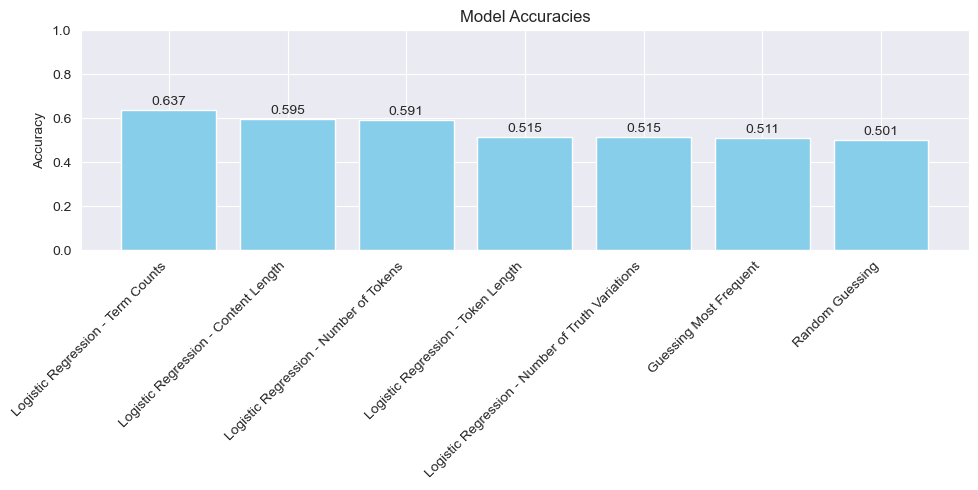

In [6]:
compare_baseline_models_on_content_features(X_train.reshape(-1, 1), y_train, X_val.reshape(-1, 1), y_val)

## Task 3

In [5]:
print('reading and splitting data...')
start_time = time.time()

path = 'bbc_cleaned.csv'
df_scraped = pd.read_csv(path)
df_scraped = prepare_data(df_scraped)

X = np.concatenate((X, np.array(df_scraped['content'] )))
y = np.concatenate((y, np.ones(len(df_scraped['content']))))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

elapsed_time = time.time() - start_time
print(f"finished reading and splitting data in: {elapsed_time:.3f} seconds")

reading and splitting data...
finished reading and splitting data in: 0.143 seconds


In [ ]:
compare_baseline_models_on_content_features(X_train.reshape(-1, 1), y_train, X_val.reshape(-1, 1), y_val,
                                            title="Model Accuracies with scraped data")

# Part 3

In [6]:
def normalize_vectors(vectors):
    """
    Normalize each vector in the list of vectors.
    Each vector is divided by its L2 norm. The vectors are assumed to be 11-dimensional,
    with the last element being the length of the text.
    """
    normalized = np.array(vectors, dtype=float)  # Ensure the array is in float for division
    norms = np.linalg.norm(normalized, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Prevent division by zero
    return normalized / norms

def count_term_occurrences_as_vectors(text):
    words = ['said', 'mr', 'new', 'iran', 'iranian', 'year', 'york', 'rec', 'main', 'newslett']
    if isinstance(text, str):
        counts = [0] * len(words)
        for i, word in enumerate(words):
            pattern = re.compile(r'\b' + word + r'\b', re.IGNORECASE)
            counts[i] = len(pattern.findall(text))
        counts.append(len(text))  # Append the length of the text as the 11th dimension
        return counts
    else:
        return [0] * (len(words) + 1)  # Include a slot for text length

In [ ]:
# Assuming X_train and X_val are defined and are arrays of text data
X_train_count_terms = np.array([count_term_occurrences_as_vectors(text) for text in X_train])
X_val_count_terms = np.array([count_term_occurrences_as_vectors(text) for text in X_val])

# Normalize the vectors
X_train_count_terms_normalized = normalize_vectors(X_train_count_terms)
X_val_count_terms_normalized = normalize_vectors(X_val_count_terms)

models = [
    'Logistic Regression',
    'Logistic Regression Normalized'
]

accuracies = [
    logistic_regression_performance(X_train_count_terms, y_train, X_val_count_terms, y_val),
    logistic_regression_performance(X_train_count_terms_normalized, y_train, X_val_count_terms_normalized, y_val, saveName="logistic_regression_vector_features.joblib")
]

display_model_comparisons(models, accuracies, title="Logistic Regression with vectors for terms")

Epoch 1/100


/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20395/20395 ━━━━━━━━━━━━━━━━━━━━ 12s 539us/step - accuracy: 0.6799 - loss: 0.6158 - val_accuracy: 0.5105 - val_loss: 1.7731 - learning_rate: 0.0010
Epoch 2/100
20395/20395 ━━━━━━━━━━━━━━━━━━━━ 11s 536us/step - accuracy: 0.6885 - loss: 0.5784 - val_accuracy: 0.4895 - val_loss: 2.1715 - learning_rate: 0.0010
Epoch 3/100
20395/20395 ━━━━━━━━━━━━━━━━━━━━ 11s 555us/step - accuracy: 0.6887 - loss: 0.5757 - val_accuracy: 0.4895 - val_loss: 1.8681 - learning_rate: 0.0010
Epoch 4/100
20395/20395 ━━━━━━━━━━━━━━━━━━━━ 11s 541us/step - accuracy: 0.6893 - loss: 0.5744 - val_accuracy: 0.5105 - val_loss: 1.4818 - learning_rate: 0.0010
Epoch 5/100
20395/20395 ━━━━━━━━━━━━━━━━━━━━ 11s 544us/step - accuracy: 0.6890 - loss: 0.5751 - val_accuracy: 0.4896 - val_loss: 1.0921 - learning_rate: 0.0010
Epoch 6/100
20395/20395 ━━━━━━━━━━━━━━━━━━━━ 11s 546us/step - accuracy: 0.6899 - loss: 0.5741 - val_accuracy: 0.4896 - val_loss: 2.2847 - learning_rate: 0.0010
Epoch 7/100
20395/20395 ━━━━━━━━━━━━━━━━━━━━ 11s 537

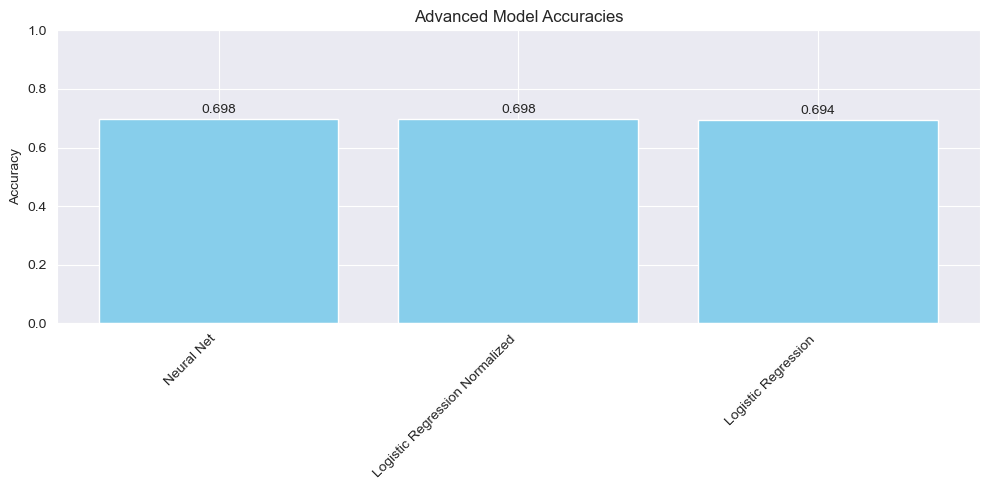

PicklingError: Can't pickle <function Layer._initializer_tracker.<locals>.<lambda> at 0x1353f4540>: it's not found as keras.src.layers.layer.Layer._initializer_tracker.<locals>.<lambda>

In [9]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras import models as md
from tensorflow.keras import callbacks

# Adjusted model architecture with more layers, neurons, dropout, and regularization
model = md.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_count_terms_normalized.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile model with the Adam optimizer and a potentially adjusted learning rate
model.compile(optimizer='adam',  # Consider experimenting with different learning rates
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model with validation data and callbacks
history = model.fit(X_train_count_terms_normalized, y_train,
                    validation_data=(X_val_count_terms_normalized, y_val),
                    epochs=100,  # Increased number of epochs with early stopping will regulate it
                    batch_size=32,  # Consider experimenting with batch size
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_count_terms_normalized, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Assuming models and accuracies lists exist for comparison purposes
models.append('Neural Net')
accuracies.append(val_accuracy)

# Assuming display_model_comparisons is a function to visualize model comparisons
display_model_comparisons(models, accuracies, title="Advanced Model Accuracies")
dump(model, "neural_net.joblib")

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load pre-trained word embeddings
print('creating embedding index')
start_time = time.time()
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
        
elapsed_time = time.time() - start_time
print(f"finished creating embedding index in: {elapsed_time:.3f} seconds")

# Assuming embedding_index is your dictionary containing word: embedding pairs from GloVe
# Function to convert articles into averaged word embeddings
def text_to_avg_vector(text_series, tokenizer, embedding_index, embedding_dim=100):
    vectors = []
    for text in text_series:
        tokens = tokenizer.texts_to_sequences([text])[0]
        article_vectors = [embedding_index.get(tokenizer.index_word[token], np.zeros(embedding_dim)) for token in tokens]
        if article_vectors:
            vectors.append(np.mean(article_vectors, axis=0))
        else:
            vectors.append(np.zeros(embedding_dim))
    return np.array(vectors)

# Tokenize text
print('fitting tokenizer')
start_time = time.time()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
elapsed_time = time.time() - start_time
print(f"finished fitting tokenizer in: {elapsed_time:.3f} seconds")

# Convert each article to averaged word embeddings
print('converting content of articles to vectors')
start_time = time.time()
X_train_embedded = text_to_avg_vector(X_train, tokenizer, embedding_index)
X_val_embedded = text_to_avg_vector(X_val, tokenizer, embedding_index)
elapsed_time = time.time() - start_time
print(f"finished converting articles in: {elapsed_time:.3f} seconds")

# Pad sequences
print('padding')
start_time = time.time()

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max([len(x) for x in X_train_sequences]))
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max([len(x) for x in X_val_sequences]))

elapsed_time = time.time() - start_time
print(f"finished padding in: {elapsed_time:.3f} seconds")

models.append('Logistic regression embedded')
accuracies.append(logistic_regression_performance(X_train_padded, y_train, X_val_padded, y_val, simple=True, saveName="logistic_regression_embedded.joblib"))
display_model_comparisons(models, accuracies, title="Advanced model accuracies")

creating embedding index
finished creating embedding index in: 4.298 seconds
fitting tokenizer
finished fitting tokenizer in: 62.516 seconds
converting content of articles to vectors
finished converting articles in: 142.901 seconds
padding
finished padding in: 46.178 seconds


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

print('naive bayes')
start_time = time.time() 

def extract_features(X):
    features = []
    for text in X:
        features.append([count_term_occurrences(text), extract_content_length(text)])
    return features

print('init vectorizer')
# TfidfVectorizer for text vectorization
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))

print('init pipeline')
# Pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', tfidf_vect)
        ])),
        ('length_features', FunctionTransformer(extract_features, validate=False)),
    ])),
    ('classifier', MultinomialNB())
])

print('fit model')
# Train the model
pipeline.fit(X_train, y_train)

print('make predictions')
# Predictions
predictions = pipeline.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

elapsed_time = time.time() - start_time
print(f"finished naive bayes in: {elapsed_time:.3f} seconds")

naive bayes
init vectorizer
init pipeline
fit model


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

print('init vectorizer...')
start_time = time.time()

# Initialize the TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = tfidf_vect.fit_transform(X_train)

elapsed_time = time.time() - start_time
print(f"finished in: {elapsed_time:.3f} seconds.")

def tf_idf_engineering(X):
    
    # Extract custom features
    custom_features = np.array([[count_term_occurrences(text), extract_content_length(text)] for text in X])
    #custom_features = np.array([[count_term_occurrences_as_vectors(text)] for text in X])
    
    # Combine TF-IDF features with custom features
    # Note: Need to convert TF-IDF sparse matrix to dense format to concatenate with custom features
    X_combined = np.hstack((X_tfidf.toarray(), custom_features))
    
    return X_combined

print('tf_idf engineering...')
start_time = time.time()
X_train_tf = tf_idf_engineering(X_train[:1000])
elapsed_time = time.time() - start_time
print(f"finished in: {elapsed_time:.3f} seconds.")
#X_val_tf = tf_idf_engineering(X_val)

print('number of inputs: ', len(X_train_tf))
print('dimensions: ', len(X_train_tf[0]))

init vectorizer...
finished in: 52.016 seconds.
tf_idf engineering...


In [8]:
print('tf_idf engineering...')
start_time = time.time()
X_train_tf = tf_idf_engineering(X_train[:2000])
elapsed_time = time.time() - start_time
print(f"finished in: {elapsed_time:.3f} seconds.")
print('number of inputs: ', len(X_train_tf))
print('dimensions: ', len(X_train_tf[0]))

tf_idf engineering...
finished in: 3.216 seconds.
number of inputs:  2000
dimensions:  403058


In [9]:
print('tf_idf engineering...')
start_time = time.time()
X_train_tf = tf_idf_engineering(X_train[:3000])
elapsed_time = time.time() - start_time
print(f"finished in: {elapsed_time:.3f} seconds.")
print('number of inputs: ', len(X_train_tf))
print('dimensions: ', len(X_train_tf[0]))

tf_idf engineering...
finished in: 5.851 seconds.
number of inputs:  3000
dimensions:  582499


In [10]:
print('tf_idf engineering...')
start_time = time.time()
X_train_tf = tf_idf_engineering(X_train[:4000])
elapsed_time = time.time() - start_time
print(f"finished in: {elapsed_time:.3f} seconds.")
print('number of inputs: ', len(X_train_tf))
print('dimensions: ', len(X_train_tf[0]))

tf_idf engineering...
finished in: 9.149 seconds.
number of inputs:  4000
dimensions:  741825


In [ ]:
print('tf_idf engineering...')
start_time = time.time()
X_train_tf = tf_idf_engineering(X_train[:10000])
elapsed_time = time.time() - start_time
print(f"finished in: {elapsed_time:.3f} seconds.")
print('number of inputs: ', len(X_train_tf))
print('dimensions: ', len(X_train_tf[0]))

tf_idf engineering...


In [1]:
print('dimensions: ', len(X_train_tf[0]))
print('dimensions: ', len(X_train_tf[1]))
print('dimensions: ', len(X_train_tf[3]))

NameError: name 'X_train_tf' is not defined

In [14]:
from sklearn.naive_bayes import MultinomialNB

print('Feature engineering for validation data')
X_val_tf = tf_idf_engineering(X_val[:1000])

print('Naive Bayes')
start_time = time.time()

# Now, directly use the engineered features with the classifier
classifier = MultinomialNB()
classifier.fit(X_train_tf, y_train[:4000])

predictions = classifier.predict(X_val_tf)
accuracy = accuracy_score(y_val[:1000], predictions)
print(f'Accuracy: {accuracy}')

elapsed_time = time.time() - start_time
print(f"Finished Naive Bayes in: {elapsed_time:.3f} seconds")

Feature engineering for validation data
Naive Bayes


ValueError: X has 212408 features, but MultinomialNB is expecting 741825 features as input.